In [1]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# Завантажемо дані з отриманих у `"variable analysis.ipynb"`

In [2]:
rakuten_modified_df = pd.read_excel('rakuten_modified.xlsx', index_col=0)
rakuten_modified_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1050 entries, 0 to 1049
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   count_car         1050 non-null   int64         
 1   date              1050 non-null   datetime64[ns]
 2   just_date         1050 non-null   datetime64[ns]
 3   Japan             1050 non-null   int64         
 4   high_temp         1050 non-null   int64         
 5   low_temp          1050 non-null   int64         
 6   rain_probability  1050 non-null   int64         
dtypes: datetime64[ns](2), int64(5)
memory usage: 65.6 KB


# Спробую трансформувати лише колонку з заброньованими авто:

In [3]:
# Залишимо дату замовлення та кількість замовлених авто
df = rakuten_modified_df.set_index('just_date')['count_car'].to_frame()

In [4]:
df.head()

,count_car
just_date,
2016-02-16,1
2016-02-17,0
2016-02-18,0
2016-02-19,1
2016-02-20,2


# Перевірка на стаціонарність

Критерій Дікі-Фуллера: p=0.0137


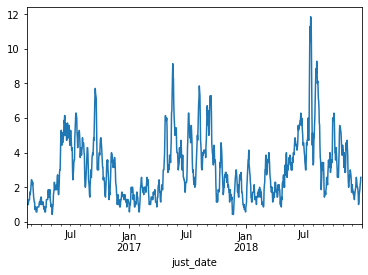

In [5]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Якщо p-value цього критерію менше, ніж 𝛼=0.05, то ряд стаціонарний.
print(f'Критерій Дікі-Фуллера: p={sm.tsa.stattools.adfuller(df)[1]:.4f}')
sm.tsa.seasonal_decompose(df).trend.plot()
plt.show()

# Бокс-Кокс трансформація
### (так як у наших даних присутні нулі ДОДАЄМО одиницю)

In [6]:
from scipy import stats
# from scipy.special import inv_boxcox

f = lambda x: x+1
df['boxcox'], lmbda = stats.boxcox(df.count_car.apply(f))

Критерій Дікі-Фуллера: p=0.0173


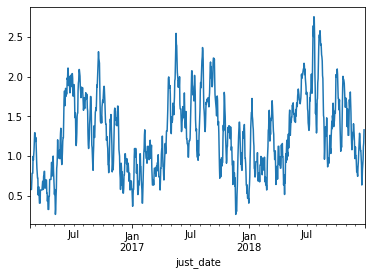

In [7]:
print(f'Критерій Дікі-Фуллера: p={sm.tsa.stattools.adfuller(df.boxcox)[1]:.4f}')
sm.tsa.seasonal_decompose(df.boxcox).trend.plot()
plt.show()

# позбавляємось сезонності

Проведемо сезонне диференціювання. Довжина сезону у нашому випадку дорівнює 12.

Критерій Дікі-Фуллера: p-value=0.0000


[]

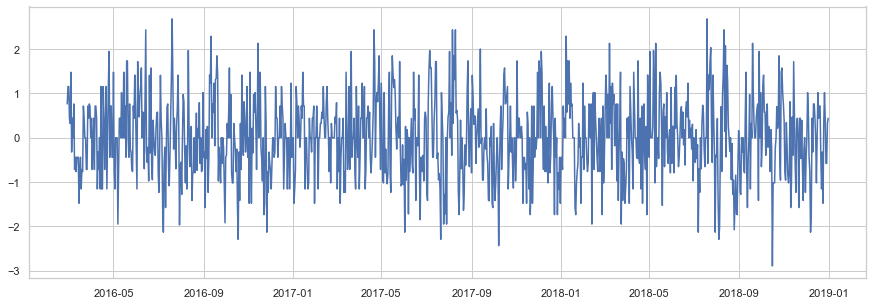

In [20]:
from scipy import stats
# from scipy.special import inv_boxcox

df['boxcox_shifted_S'] = df.boxcox - df.boxcox.shift(12)

p = sm.tsa.stattools.adfuller(df.boxcox_shifted_S[12:])[1]
print(f'Критерій Дікі-Фуллера: p-value={p:.4f}')
fig , ax = plt.subplots(figsize=(15,5))
# df.boxcox_shifted_S[12:].plot()
ax.plot(df.boxcox_shifted_S[12:])
plt.plot()

# Повернемо предиктори погоди, свят та додамо нові часові:

In [9]:
df[12:]['boxcox_shifted_S']

just_date
2016-02-28    0.762756
2016-02-29    1.155972
2016-03-01    1.155972
2016-03-02    0.440277
2016-03-03    0.322479
                ...   
2018-12-27    0.440277
2018-12-28   -0.578550
2018-12-29   -0.578550
2018-12-30    0.322479
2018-12-31    0.440277
Name: boxcox_shifted_S, Length: 1038, dtype: float64

In [10]:
df_with_predictors = df.merge(rakuten_modified_df, on=['just_date'])


In [11]:
df_with_predictors = df_with_predictors.set_index('just_date')

In [12]:
# Позбудемося зайвих колонок
df_with_predictors = df_with_predictors[12:][['boxcox_shifted_S', 'Japan', 'high_temp', 'low_temp', 'rain_probability']]

In [13]:
df_with_predictors

,boxcox_shifted_S,Japan,high_temp,low_temp,rain_probability
just_date,,,,,
2016-02-28,0.762756,0,26,22,20
2016-02-29,1.155972,0,28,21,20
2016-03-01,1.155972,0,27,22,20
2016-03-02,0.440277,0,27,22,20
2016-03-03,0.322479,0,27,22,20
...,...,...,...,...,...
2018-12-27,0.440277,0,17,13,80
2018-12-28,-0.578550,0,17,13,80
2018-12-29,-0.578550,0,16,12,80


# Додамо предиктори часу:

In [14]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df.pop('date')

    return df


In [15]:
data_frame = create_features(df_with_predictors)

<h1 style='color:red'>Тепер виникло питання, що мені зробити далі?</h1>


* Таким же чином трансформувати інші змінні, чи залишити як є
* Чи провести їх глибокий аналіз, і що б потрібно було зробити?

# Спробую трансформувати всі дані, та глянути, що вийшло:
на цей раз позбавлюсь нулів у всіх даних

In [66]:
# сформую новий DataFrame
data = rakuten_modified_df.copy()
data = data.set_index('just_date')
data.pop('date')

,count_car,date,just_date,Japan,high_temp,low_temp,rain_probability
0,1,2016-02-16,2016-02-16,0,25,19,50
1,0,2016-02-17,2016-02-17,0,26,20,50
2,0,2016-02-18,2016-02-18,0,28,21,50
3,1,2016-02-19,2016-02-19,0,28,20,30
4,2,2016-02-20,2016-02-20,0,28,19,50
...,...,...,...,...,...,...,...
1045,2,2018-12-27,2018-12-27,0,17,13,80
1046,2,2018-12-28,2018-12-28,0,17,13,80
1047,2,2018-12-29,2018-12-29,0,16,12,80
1048,3,2018-12-30,2018-12-30,0,19,14,50


In [68]:
data.describe() # Як видно нулі присутні в стобцях count_car, Japan, та rain_probability

,count_car,Japan,high_temp,low_temp,rain_probability
count,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000
mean,3.058095,0.091429,27.964762,19.120000,23.809524
std,2.649434,0.288355,3.700887,1.967534,23.970945
min,0.000000,0.000000,15.000000,12.000000,0.000000
25%,1.000000,0.000000,26.000000,18.000000,0.000000
50%,2.000000,0.000000,28.000000,19.000000,10.000000
75%,4.000000,0.000000,31.000000,21.000000,50.000000
max,20.000000,1.000000,36.000000,23.000000,80.000000


In [39]:
# додам одиницю до всього DataFrame
data_plus_one = data+1

In [40]:
data_plus_one.describe()

,count_car,Japan,high_temp,low_temp,rain_probability
count,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000
mean,4.058095,1.091429,28.964762,20.120000,24.809524
std,2.649434,0.288355,3.700887,1.967534,23.970945
min,1.000000,1.000000,16.000000,13.000000,1.000000
25%,2.000000,1.000000,27.000000,19.000000,1.000000
50%,3.000000,1.000000,29.000000,20.000000,11.000000
75%,5.000000,1.000000,32.000000,22.000000,51.000000
max,21.000000,2.000000,37.000000,24.000000,81.000000


In [46]:
# прологарифмую отриманий DataFrame
import numpy as np
log_data = data_plus_one.applymap(lambda x : np.log(x))

[]

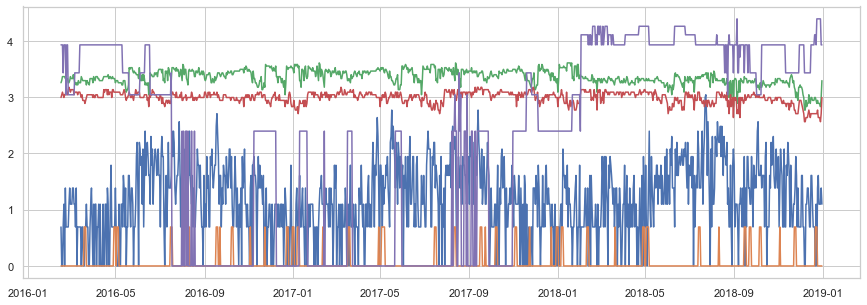

In [47]:
# позбавлюсь сезонності


[]

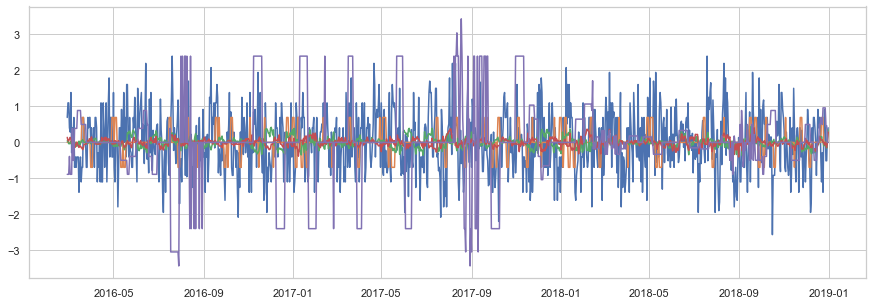

In [69]:
log_data_shift = log_data.shift(12) #отримаємо Індекс зсуву на бажану кількість періодів == 12
# поправимо логарифмовані дані на отриманий індекс
fig , ax = plt.subplots(figsize=(15,5))
ax.plot(log_data - log_data_shift)
plt.plot()

In [ ]:
# відобразимо розподіл та кореляцію між предикторами стаціонарного ряду
stationary_df = log_data - log_data_shift
stationary_df.boxplot()

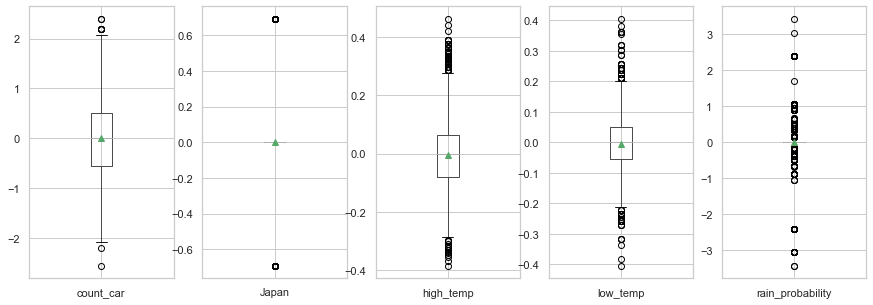

In [65]:
def view_boxplot(df):
    fig, axs = plt.subplots(ncols=len(df.columns), figsize=(15,5))
    for col_name, ax in zip(df.columns, axs):
        df.boxplot(column=col_name, ax=ax, showmeans=True)
    
view_boxplot(stationary_df[12:])

In [53]:
def corr_show(df):
#     rak_features = rak[['high_temp', 'low_temp', 'rain_probability', 'Japan', 'count_car']]
    axes = pd.plotting.scatter_matrix(df, figsize=(10,10), diagonal='kde', grid=True)
    corr = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
        axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')
    plt.show()

corr_show(stationary_df[12:])

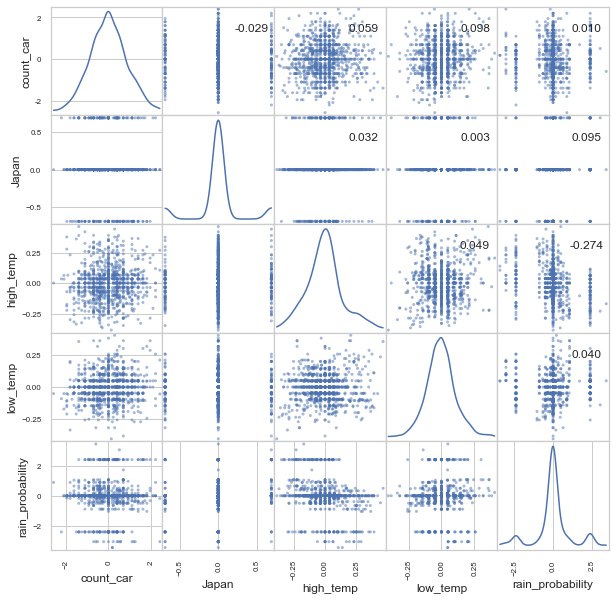

In [64]:
corr_show(stationary_df[12:])

In [70]:
# Cхоже розподіл даних наближається до нормального
# проведемо класичні тести на нормальність даних
import scipy.stats as stats
from scipy.stats import anderson, kstest, shapiro, chisquare
from statsmodels.stats.diagnostic import lilliefors

def conclusions(test):
    def wraper(sample):
        statistic, pvalue = test(sample)
        if pvalue < 0.05:
            print(f'{statistic=} {pvalue=} < 0.05, data does NOT look NORMAL (reject H0)')
            print('!!!')
        else:
            print(f'{statistic=:0.2f} {pvalue=:0.2f} > 0.05, data looks NORMAL (fail to reject H0)')
    return wraper

# Критерій Шапіро-Уїлка        
@conclusions        
def Shapiro(sample):
    print('ShapiroResult')
    statistic, pvalue = stats.shapiro(sample)
    return statistic, pvalue

# Критерій Колмогорова-Смирнова 
@conclusions
def KS(sample):
    print('KstestResult')
    statistic, pvalue = stats.kstest(sample, 'norm')
    return statistic, pvalue

# Критерій Лілієфорса
@conclusions
def Lilliefors_test(sample):
    print('LillieforsResult')
    statistic, pvalue = lilliefors(sample)
    return statistic, pvalue
    
# Критерій Андерсона-Дарлінга
def Anderson_Darling_test(sample):
    print('AndersonDarlingResult')
    result = anderson(sample)
    print('Statistic: %.3f' % result.statistic)
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
        else:
            print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))
            print('!!!')

In [88]:
# rak_features = rak[['high_temp', 'low_temp', 'rain_probability', 'count_car']]

def normality_tests(df):
    for feature in df.columns:
        print(f'========================={feature}=========================')
        KS(df[f'{feature}'])
        Lilliefors_test(df[f'{feature}'])
        Shapiro(df[f'{feature}'])
        Anderson_Darling_test(df[f'{feature}'])
# ВСІ ТЕСТИ ГОВОРЯТЬ ПРО низьку ІМОВІРНІСТЬ ТОГО ЩО ДАНІ РОЗПОДІЛЕНІ НОРМАЛЬНО
normality_tests(stationary_df[12:])

=========================count_car=========================
KstestResult
statistic=0.08514905821332841 pvalue=5.373559563492185e-07 < 0.05, data does NOT look NORMAL (reject H0)
!!!
LillieforsResult
statistic=0.08642021178757475 pvalue=0.0009999999999998899 < 0.05, data does NOT look NORMAL (reject H0)
!!!
ShapiroResult
statistic=0.993961751461029 pvalue=0.0003360881528351456 < 0.05, data does NOT look NORMAL (reject H0)
!!!
AndersonDarlingResult
Statistic: 2.705
15.000: 0.574, data does not look normal (reject H0)
!!!
10.000: 0.653, data does not look normal (reject H0)
!!!
5.000: 0.784, data does not look normal (reject H0)
!!!
2.500: 0.914, data does not look normal (reject H0)
!!!
1.000: 1.088, data does not look normal (reject H0)
!!!
=========================Japan=========================
KstestResult
statistic=0.41136801541425816 pvalue=2.060382392916811e-159 < 0.05, data does NOT look NORMAL (reject H0)
!!!
LillieforsResult
statistic=0.41119308847226643 pvalue=0.000999999999999

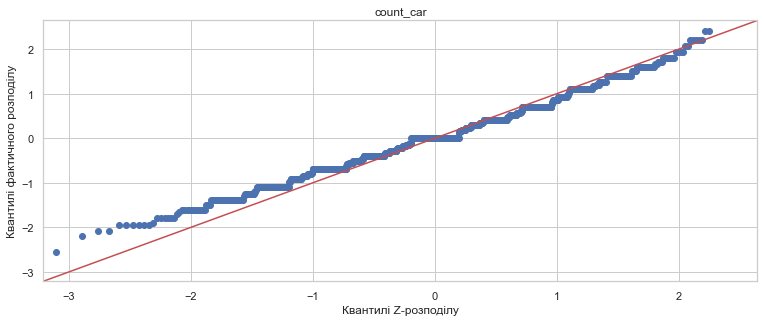

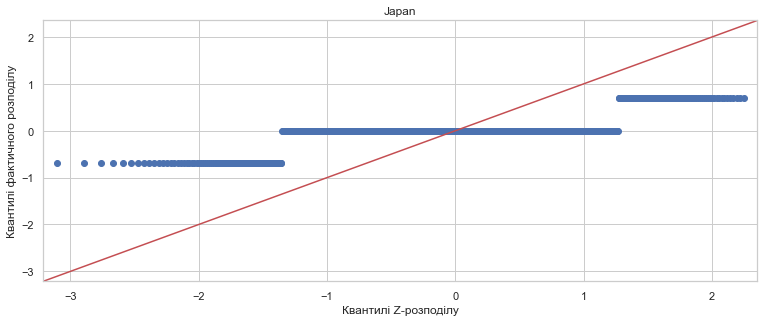

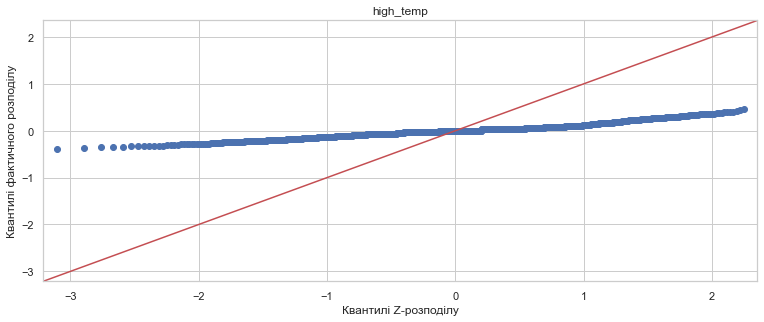

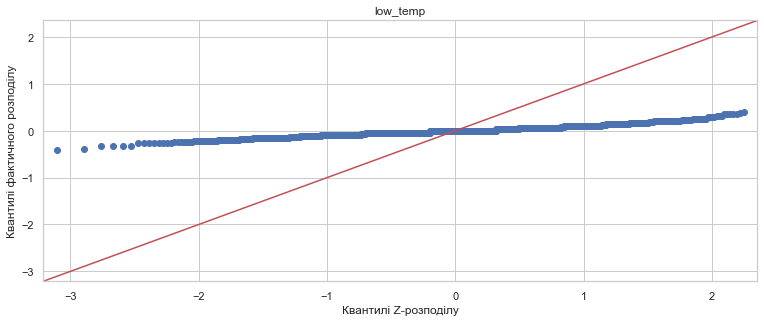

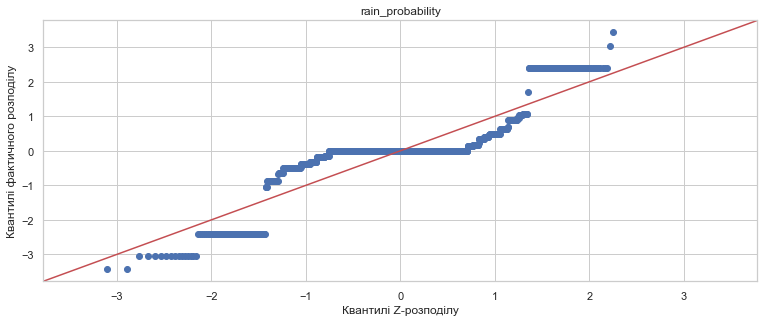

In [87]:
# побудуємо квантиль-квантильний графік(QQ plot)
def QQ(df, col_name):
    plt.figure(figsize = [6.4*2, 4.8])  # Створюємо фігуру qq_plot
    ax = plt.subplot()
    sm.qqplot(df[col_name], line ='45', ax=ax)

    ax.set_title(f'{feature}')  # Заголовок
    ax.set_xlabel('Квантилі Z-розподілу')  # Підпис по осі X
    ax.set_ylabel('Квантилі фактичного розподілу')  # Підпис по осі Y
    ax.grid(True)  # Увімкнути сітку


for feature in stationary_df.columns:
    QQ(stationary_df, feature)
    
# Схоже що лише змінна count_car наближається до нормального розподілу